<a href="https://colab.research.google.com/github/jvitordeoliveira96/MATH7924/blob/restore/2_Minimize_kl_divergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Minimize KL-divergence between two distributions**

**(Adapted from https://github.com/probml/pyprobml/blob/auto_notebooks_md/notebooks.md#minimize_kl_divergence.ipynb)**

This follows from the textbook example: let $p \sim \frac{1}{2}\mathcal{N}(1,1) + \frac{1}{2} \mathcal{N}(10,1.5)$ and $q \sim \mathcal{N}(\mu, \sigma^2)$. We would like to compare the results of

- Forward KL divergence minimization
$$q = \text{argmin}_{\mu, \sigma^2} D_{\mathrm{KL}}(p \| q)$$

- Reverse KL divergence minimization
$$q = \text{argmin}_{\mu, \sigma^2} D_{\mathrm{KL}}(q \| p)$$

From the textbook: To prevent $ D_{\mathrm{KL}}(p \| q)$ from becoming infinite, we must have $q > 0$ whenever $p > 0$ (i.e., $q$ must have support everywhere $p$ does), so $q$ tends to cover both modes as it must be nonvanishing everywhere $p$ is; this is called **mode-covering** or **zero-avoiding** behavior. By contrast, to prevent $D_{\mathrm{KL}}(q \| p)$ from becoming infinite, we must have $q = 0$ whenever $p = 0$, which creates **mode-seeking** or **zero-forcing** behavior.




In [ ]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import time

try:
    import distrax
except:
    %pip install -qq distrax
    import distrax
try:
    import optax
except:
    %pip install -qq optax
    import optax
try:
    import seaborn as sns
except:
    %pip install -qq seaborn
    import seaborn as sns

#from jax.config import config

#config.update("jax_enable_x64", True)

In [ ]:
# for making the book figures
if False:
    import os

    os.environ["LATEXIFY"] = "1"
    os.environ["FIG_DIR"] = "/Users/kpmurphy/github/bookv2/figures"
    latexify(width_scale_factor=1.6, fig_height=1.0)

In [ ]:
# generating a bimodal distribution ptrue
mix = 0.5
mean_one, mean_two = 1, 10
scale_one, scale_two = 1, 1.5
ptrue = distrax.MixtureSameFamily(
    mixture_distribution=distrax.Categorical(probs=[mix, 1 - mix]),
    components_distribution=distrax.Normal(loc=[mean_one, mean_two], scale=[scale_one, scale_two]),
)

/usr/local/lib/python3.11/dist-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [ ]:
key = jax.random.PRNGKey(1234)


def kl_sampling_inverse(params, p, samples=100000):  # loss function when KL(q:p)
    """ Computes Monte Carlo approximation of KL(q||p) by
    generating samples from q"""

    q = distrax.Normal(loc=params[0], scale=params[1])
    sample_set = q.sample(seed=key, sample_shape=samples)
    return jnp.mean(q.log_prob(sample_set) - p.log_prob(sample_set))


def kl_sampling(params, p, samples=100000):  # loss function when KL(p:q)
    """ Computes Monte Carlo approximation of KL(p||q) by
    generating samples from p"""

    q = distrax.Normal(loc=params[0], scale=params[1])
    sample_set = p.sample(seed=key, sample_shape=samples)
    return jnp.mean(p.log_prob(sample_set) - q.log_prob(sample_set))

In [ ]:
def fit(params, optimizer, loss_fun, n_itr, save_param_iters = False):
    opt_state = optimizer.init(params)
    loss_iters, params_iters = [], []
    fn = jax.jit(jax.value_and_grad(loss_fun))
    for i in range(n_itr):
        samples = 8000
        # Better design: passing q(params) instead.
        loss_value, grads = jax.value_and_grad(loss_fun)(params, ptrue, samples)
        # loss_value, grads = fn(params, ptrue, samples)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        loss_iters.append(loss_value)
        if save_param_iters:
          params_iters.append(params)

    if save_param_iters:
      return params, loss_iters, params_iters

    return params, loss_iters

In [ ]:
optimizer = optax.adam(learning_rate=0.05)
n_itr = 300

# First, do the reverse KL minimization 7 times (for measuring average computation time)
nruns = 7
exec_time_one = []
for i in range(0, nruns):
  params_one = jnp.array([1.0, 1.25])
  exec_time_0 = time.time()
  optimized_params_one, loss_one = fit(params=params_one, optimizer=optimizer, loss_fun=kl_sampling_inverse, n_itr=n_itr)
  exec_time_one.append(time.time() - exec_time_0)

print(f"Reverse KL optmization: Average Time = {sum(exec_time_one)/nruns:.4f}s")

Reverse KL optmization: Average Time = 18.4907s


In [ ]:
# Second, do the forward KL minimization 7 times (for measuring average computation time)
nruns = 7
exec_time_two = []
for i in range(0, nruns):
  params_two = jnp.array([5.0, 10.0])
  exec_time_0 = time.time()
  optimized_params_two, loss_two = fit(params=params_two, optimizer=optimizer, loss_fun=kl_sampling, n_itr=n_itr)
  exec_time_two.append(time.time() - exec_time_0)

print(f"Forward KL optmization: Average Time = {sum(exec_time_two)/nruns:.4f}s")


Forward KL optmization: Average Time = 19.1636s


Text(0.5, 1.0, 'Iteration vs loss\n$\\min_{q}\\ KL[p ; q]$')

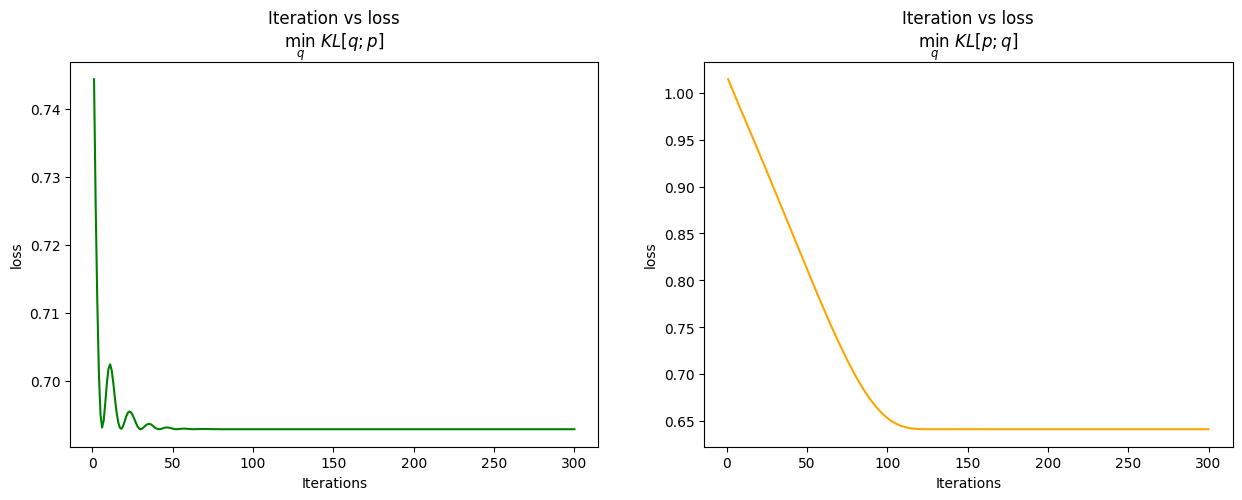

In [ ]:
x_loss = jnp.linspace(1, n_itr, n_itr)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(x_loss, loss_one, color="green")
ax2.plot(x_loss, loss_two, color="orange")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("loss")
ax1.set_title("Iteration vs loss\n" + r"$\min_{q}\ KL[q ; p]$")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("loss")
ax2.set_title("Iteration vs loss\n" + r"$\min_{q}\ KL[p ; q]$")

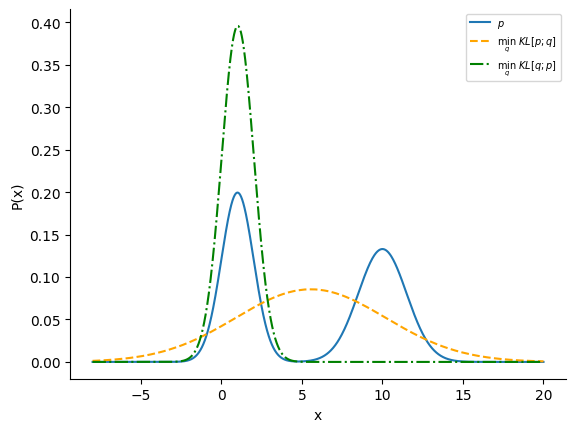

In [ ]:
fig, ax = plt.subplots(1, 1)
x = jnp.linspace(-8, 20, int(1e6))
#label_one = str()
#label_two = str()
label_one = r"$\min_q\ KL[q ; p]$"
label_two = r"$\min_q\ KL[p ; q]$"
ax.plot(x, ptrue.prob(x), label=r"$p$")
ax.plot(
    x,
    distrax.Normal(loc=optimized_params_two[0], scale=optimized_params_two[1]).prob(x),
    color="orange",
    label=label_two,
    linestyle="--",
)
ax.plot(
    x,
    distrax.Normal(loc=optimized_params_one[0], scale=optimized_params_one[1]).prob(x),
    color="green",
    label=label_one,
    linestyle="-.",
)
ax.set_xlabel("x")
ax.set_ylabel("P(x)")
ax.legend(fontsize=7, loc="upper right")
sns.despine()
#savefig("minimize_kl_divergence_latexified")

In [ ]:
def kl_forward(params, samples=20000):
    """KL(ptrue || q)"""
    mu, sigma = params
    q = distrax.Normal(loc=mu, scale=sigma)
    x = ptrue.sample(seed=key_forward, sample_shape=(samples,))
    return jnp.mean(ptrue.log_prob(x) - q.log_prob(x))

def kl_reverse(params, samples=20000):
    """KL(q || ptrue)"""
    mu, sigma = params
    q = distrax.Normal(loc=mu, scale=sigma)
    x = q.sample(seed=key_reverse, sample_shape=(samples,))
    return jnp.mean(q.log_prob(x) - ptrue.log_prob(x))

# 3.1) Create grid for mu ∈ [3.5,7], sigma ∈ [2,10] (for reverse)
locs0 = jnp.linspace(3.5, 7, 120)
scales0 = jnp.linspace(2, 10, 120)
Locs0, Scales0 = jnp.meshgrid(locs0, scales0)

# 3.2) Create grid for mu ∈ [-2,12], sigma ∈ [0.5,10] (for reverse)
locs = jnp.linspace(-2, 12, 120)
scales = jnp.linspace(0.1, 10.0, 120)
Locs, Scales = jnp.meshgrid(locs, scales)

# 4) Vectorized / JIT‐compiled grid computation
key = jax.random.PRNGKey(1234)
key_forward, key_reverse = jax.random.split(key)

@jax.jit
def compute_grid_forward(locs, scales, key):
    def kl_fwd_single(mu, sigma, seed):
        q = distrax.Normal(loc=mu, scale=sigma)
        x = ptrue.sample(seed=seed, sample_shape=(num_samples,))
        return jnp.mean(ptrue.log_prob(x) - q.log_prob(x))
    # split keys for reproducibility
    keys = jax.random.split(key, locs.size)
    # vectorize over the flattened grid
    flat_vals = jax.vmap(
        lambda mu, sigma, k: kl_fwd_single(mu, sigma, k)
    )(locs.ravel(), scales.ravel(), keys)
    return flat_vals.reshape(locs.shape)

@jax.jit
def compute_grid_reverse(locs, scales, key):
    def kl_rev_single(mu, sigma, seed):
        q = distrax.Normal(loc=mu, scale=sigma)
        x = q.sample(seed=seed, sample_shape=(num_samples,))
        return jnp.mean(q.log_prob(x) - ptrue.log_prob(x))
    keys = jax.random.split(key, locs.size)
    flat_vals = jax.vmap(
        lambda mu, sigma, k: kl_rev_single(mu, sigma, k)
    )(locs.ravel(), scales.ravel(), keys)
    return flat_vals.reshape(locs.shape)

# 5) Compute with fresh keys and plot
num_samples = 7500
key = jax.random.PRNGKey(1234)
key_fwd, key_rev = jax.random.split(key)

KL_fwd = compute_grid_forward(Locs0, Scales0, key_fwd)
KL_rev = compute_grid_reverse(Locs, Scales, key_rev)


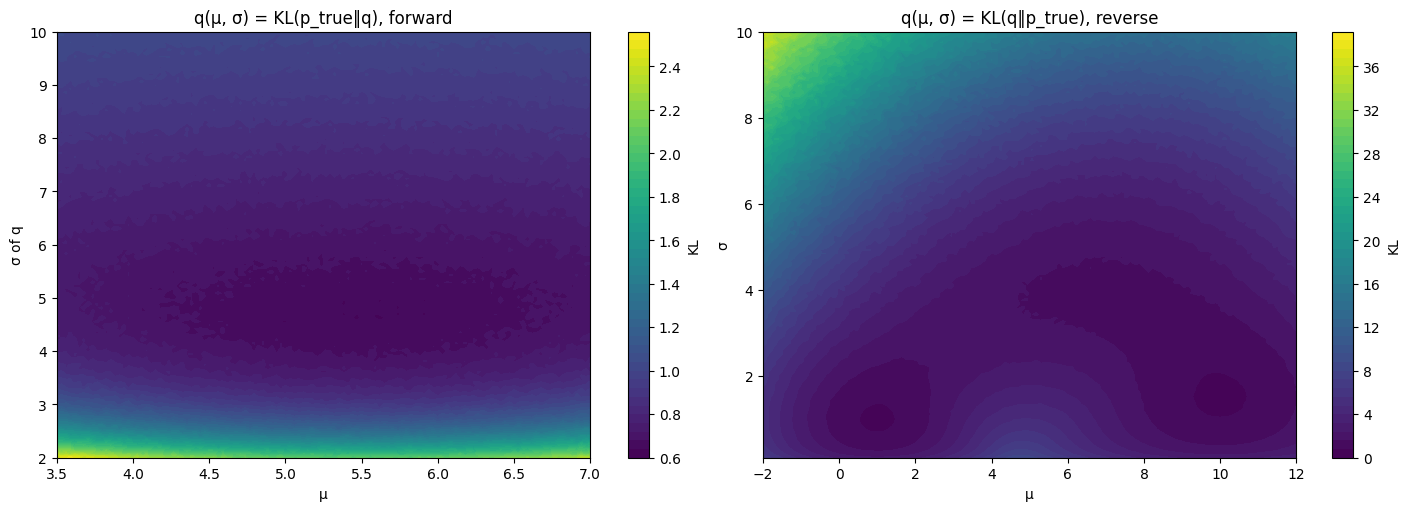

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
cf1 = ax1.contourf(Locs0, Scales0, (KL_fwd), levels=50, cmap='viridis')
ax1.set(title='q(μ, σ) = KL(p_true‖q), forward', xlabel='μ', ylabel='σ of q')
fig.colorbar(cf1, ax=ax1, label='KL')

cf2 = ax2.contourf(Locs, Scales, (KL_rev), levels=50, cmap='viridis')
ax2.set(title='q(μ, σ) = KL(q‖p_true), reverse', xlabel='μ', ylabel='σ')
fig.colorbar(cf2, ax=ax2, label='KL')

plt.show()


In [ ]:
kl_reverse(jnp.array([1.0, 1]))

Array(0.69288033, dtype=float32)

In [ ]:
kl_reverse(jnp.array([10, 1.5]))

Array(0.69230884, dtype=float32)

We notice from the contour plot of the forward KL divergence $D_{\mathrm{KL}}(p \| q)$ that there is only one global minimum that is captured by the numerical minimization process using Adam method. On the other hand, the contour plot of the reverse KL divergence $D_{\mathrm{KL}}(q \| p)$ has two global minima, which is in agreement with the **mode-seeking** behavior: it does not matter which "mode" is choosen, as long as only one is covered to ensure the condition of having $q = 0$ whenever $p = 0$.

# What if $q$ is a mixture of two gaussians (bimodal) instead?

We may now perform the same procedure, now considering $q$ is of the same family as $p$ (it is a mixture of two Gaussians).

In [ ]:
# generating a bimodal distribution ptrue
mix = 0.5
mean_one, mean_two = 1, 10
scale_one, scale_two = 1, 1.5
ptrue = distrax.MixtureSameFamily(
    mixture_distribution=distrax.Categorical(probs=[mix, 1 - mix]),
    components_distribution=distrax.Normal(loc=[mean_one, mean_two], scale=[scale_one, scale_two]),
)

/usr/local/lib/python3.11/dist-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [ ]:
key = jax.random.PRNGKey(1234)


def kl_sampling_inverse(params, p, samples=100000):  # loss function when KL(q:p)
    """ Computes Monte Carlo approximation of KL(q||p) by
    generating samples from q"""

    mean_one, scale_one = params[0], params[1]
    mean_two, scale_two = params[2], params[3]
    mix = 0.5 # fixed, not being optimized

    q = distrax.MixtureSameFamily(
        mixture_distribution=distrax.Categorical(probs=[mix, 1 - mix]),
        components_distribution=distrax.Normal(loc=[mean_one, mean_two], scale=[scale_one, scale_two]),
      )
    sample_set = q.sample(seed=key, sample_shape=samples)
    return jnp.mean(q.log_prob(sample_set) - p.log_prob(sample_set))


def kl_sampling(params, p, samples=100000):  # loss function when KL(p:q)
    """ Computes Monte Carlo approximation of KL(p||q) by
    generating samples from p"""

    mean_one, scale_one = params[0], params[1]
    mean_two, scale_two = params[2], params[3]
    mix = 0.5 # fixed, not being optimized

    q = distrax.MixtureSameFamily(
        mixture_distribution=distrax.Categorical(probs=[mix, 1 - mix]),
        components_distribution=distrax.Normal(loc=[mean_one, mean_two], scale=[scale_one, scale_two]),
      )
    sample_set = p.sample(seed=key, sample_shape=samples)
    return jnp.mean(p.log_prob(sample_set) - q.log_prob(sample_set))

## Sucessful optimization case

In [ ]:
optimizer = optax.adam(learning_rate=0.05)
n_itr = 1000
# First, do the reverse KL minimization
params_one = jnp.array([1.0, 1.25, 8, 1.0])
optimized_params_one, loss_one = fit(params=params_one, optimizer=optimizer, loss_fun=kl_sampling_inverse, n_itr=n_itr)
# Second, do the forward KL minimization
params_two = jnp.array([5.0, 10.0, 8.0, 1.0])
optimized_params_two, loss_two = fit(params=params_two, optimizer=optimizer, loss_fun=kl_sampling, n_itr=n_itr)

Text(0.5, 1.0, 'Iteration vs loss\n$\\min_{q}\\ KL[p ; q]$')

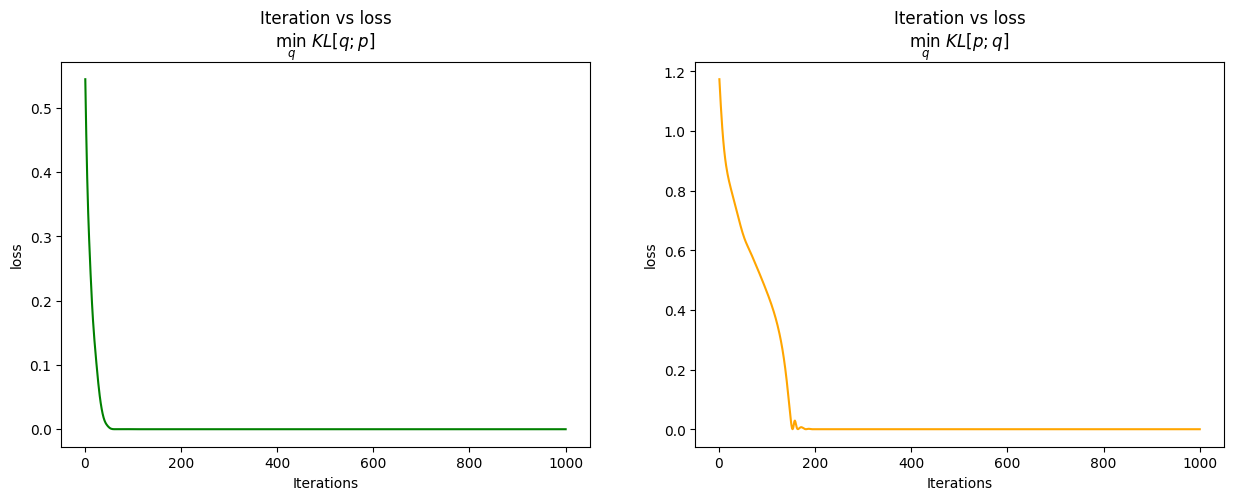

In [ ]:
x_loss = jnp.linspace(1, n_itr, n_itr)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(x_loss, loss_one, color="green")
ax2.plot(x_loss, loss_two, color="orange")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("loss")
ax1.set_title("Iteration vs loss\n" + r"$\min_{q}\ KL[q ; p]$")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("loss")
ax2.set_title("Iteration vs loss\n" + r"$\min_{q}\ KL[p ; q]$")

In [ ]:
mix = 0.5
q_reverse = distrax.MixtureSameFamily(
    mixture_distribution=distrax.Categorical(probs=[mix, 1 - mix]),
    components_distribution=distrax.Normal(loc=[optimized_params_one[0],
                                                optimized_params_one[2]],
                                           scale=[optimized_params_one[1],
                                                  optimized_params_one[3]]),
)
q_forward = distrax.MixtureSameFamily(
    mixture_distribution=distrax.Categorical(probs=[mix, 1 - mix]),
    components_distribution=distrax.Normal(loc=[optimized_params_two[0],
                                                optimized_params_two[2]],
                                           scale=[optimized_params_two[1],
                                                  optimized_params_two[3]]),
)

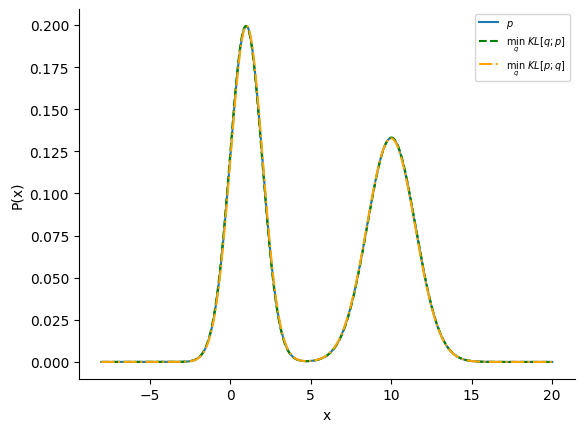

In [ ]:
fig, ax = plt.subplots(1, 1)
x = jnp.linspace(-8, 20, int(1e6))
label_one = r"$\min_q\ KL[q ; p]$"
label_two = r"$\min_q\ KL[p ; q]$"
ax.plot(x, ptrue.prob(x), label=r"$p$")
ax.plot(x, q_reverse.prob(x), color="green", label=label_one, linestyle="--")
ax.plot(x, q_forward.prob(x), color="orange", label=label_two, linestyle="-.")
ax.set_xlabel("x")
ax.set_ylabel("P(x)")
ax.legend(fontsize=7, loc="upper right")
sns.despine()
#savefig("minimize_kl_divergence_latexified")

In [ ]:
# Optimal params for reverse DKL
optimized_params_one

Array([ 0.9802885,  0.9999101, 10.013315 ,  1.4971975], dtype=float32)

In [ ]:
# Optimal params for forward DKL
optimized_params_two

Array([1.0197929, 1.0002108, 9.986752 , 1.5026644], dtype=float32)

## Failed case (local optimum in reverse DKL - left mode)

In [ ]:
optimizer = optax.adam(learning_rate=0.05)
n_itr = 1000
# First, do the reverse KL minimization
params_one = jnp.array([1.0, 1.25, 2, 1.0])
optimized_params_one, loss_one = fit(params=params_one, optimizer=optimizer, loss_fun=kl_sampling_inverse, n_itr=n_itr)
# Second, do the forward KL minimization
params_two = jnp.array([5.0, 10.0, 2.0, 1.0])
optimized_params_two, loss_two = fit(params=params_two, optimizer=optimizer, loss_fun=kl_sampling, n_itr=n_itr)

Text(0.5, 1.0, 'Iteration vs loss\n$\\min_{q}\\ KL[p ; q]$')

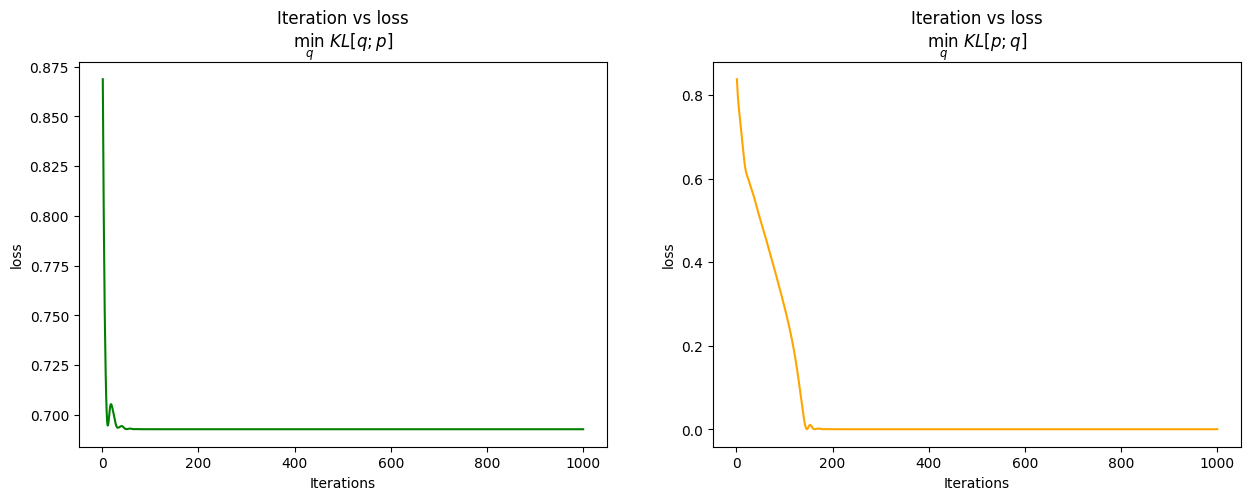

In [ ]:
x_loss = jnp.linspace(1, n_itr, n_itr)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(x_loss, loss_one, color="green")
ax2.plot(x_loss, loss_two, color="orange")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("loss")
ax1.set_title("Iteration vs loss\n" + r"$\min_{q}\ KL[q ; p]$")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("loss")
ax2.set_title("Iteration vs loss\n" + r"$\min_{q}\ KL[p ; q]$")

In [ ]:
mix = 0.5
q_reverse = distrax.MixtureSameFamily(
    mixture_distribution=distrax.Categorical(probs=[mix, 1 - mix]),
    components_distribution=distrax.Normal(loc=[optimized_params_one[0],
                                                optimized_params_one[2]],
                                           scale=[optimized_params_one[1],
                                                  optimized_params_one[3]]),
)
q_forward = distrax.MixtureSameFamily(
    mixture_distribution=distrax.Categorical(probs=[mix, 1 - mix]),
    components_distribution=distrax.Normal(loc=[optimized_params_two[0],
                                                optimized_params_two[2]],
                                           scale=[optimized_params_two[1],
                                                  optimized_params_two[3]]),
)

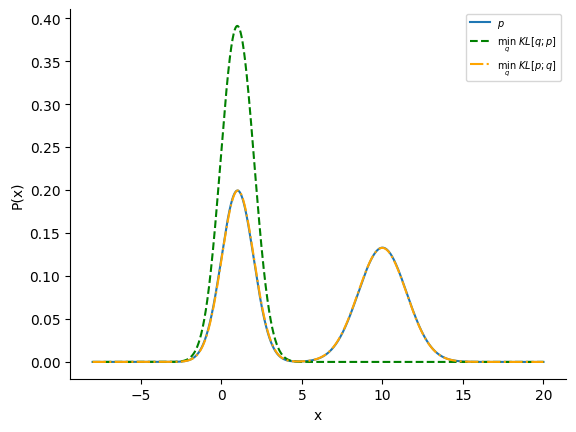

In [ ]:
fig, ax = plt.subplots(1, 1)
x = jnp.linspace(-8, 20, int(1e6))
label_one = r"$\min_q\ KL[q ; p]$"
label_two = r"$\min_q\ KL[p ; q]$"
ax.plot(x, ptrue.prob(x), label=r"$p$")
ax.plot(x, q_reverse.prob(x), color="green", label=label_one, linestyle="--")
ax.plot(x, q_forward.prob(x), color="orange", label=label_two, linestyle="-.")
ax.set_xlabel("x")
ax.set_ylabel("P(x)")
ax.legend(fontsize=7, loc="upper right")
sns.despine()
#savefig("minimize_kl_divergence_latexified")

## Failed case (local optimum in reverse DKL - right mode)

In [ ]:
optimizer = optax.adam(learning_rate=0.05)
n_itr = 1000
# First, do the reverse KL minimization
params_one = jnp.array([9.0, 1.25, 10.5, 1.7])
optimized_params_one, loss_one = fit(params=params_one, optimizer=optimizer, loss_fun=kl_sampling_inverse, n_itr=n_itr)
# Second, do the forward KL minimization
params_two = jnp.array([9.0, 1.25, 10.5, 1.7])
optimized_params_two, loss_two = fit(params=params_two, optimizer=optimizer, loss_fun=kl_sampling, n_itr=n_itr)

Text(0.5, 1.0, 'Iteration vs loss\n$\\min_{q}\\ KL[p ; q]$')

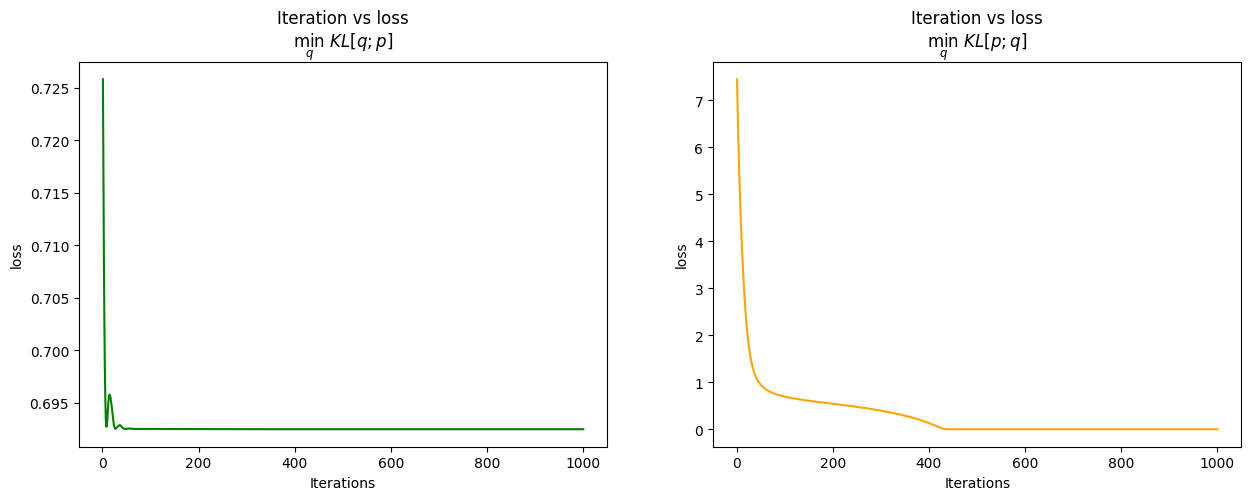

In [ ]:
x_loss = jnp.linspace(1, n_itr, n_itr)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(x_loss, loss_one, color="green")
ax2.plot(x_loss, loss_two, color="orange")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("loss")
ax1.set_title("Iteration vs loss\n" + r"$\min_{q}\ KL[q ; p]$")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("loss")
ax2.set_title("Iteration vs loss\n" + r"$\min_{q}\ KL[p ; q]$")

In [ ]:
mix = 0.5
q_reverse = distrax.MixtureSameFamily(
    mixture_distribution=distrax.Categorical(probs=[mix, 1 - mix]),
    components_distribution=distrax.Normal(loc=[optimized_params_one[0],
                                                optimized_params_one[2]],
                                           scale=[optimized_params_one[1],
                                                  optimized_params_one[3]]),
)
q_forward = distrax.MixtureSameFamily(
    mixture_distribution=distrax.Categorical(probs=[mix, 1 - mix]),
    components_distribution=distrax.Normal(loc=[optimized_params_two[0],
                                                optimized_params_two[2]],
                                           scale=[optimized_params_two[1],
                                                  optimized_params_two[3]]),
)

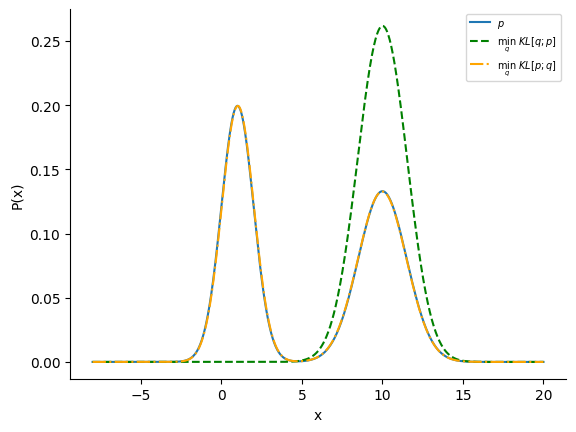

In [ ]:
fig, ax = plt.subplots(1, 1)
x = jnp.linspace(-8, 20, int(1e6))
label_one = r"$\min_q\ KL[q ; p]$"
label_two = r"$\min_q\ KL[p ; q]$"
ax.plot(x, ptrue.prob(x), label=r"$p$")
ax.plot(x, q_reverse.prob(x), color="green", label=label_one, linestyle="--")
ax.plot(x, q_forward.prob(x), color="orange", label=label_two, linestyle="-.")
ax.set_xlabel("x")
ax.set_ylabel("P(x)")
ax.legend(fontsize=7, loc="upper right")
sns.despine()
#savefig("minimize_kl_divergence_latexified")